In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [36]:
data = pd.read_csv("final_cleaned_data.csv", sep=';')

In [37]:
data = data.groupby('id')[['Danceability', 'Energy', 'Loudness_norm', 'Speechiness', 
                       'Acousticness', 'Instrumentalness', 'Valence']].first().reset_index()

In [38]:
data.head()

,id,Danceability,Energy,Loudness_norm,Speechiness,Acousticness,Instrumentalness,Valence
0,000xQL6tZNLJzIrtIgxqSl,0.748,0.627,0.825120,0.064,0.131,0.0,0.524
1,003VDDA7J3Xb2ZFlNx7nIZ,0.842,0.578,0.824511,0.138,0.004,0.0,0.190
2,003eoIwxETJujVWmNFMoZy,0.353,0.755,0.817955,0.733,0.082,0.0,0.437
3,003vvx7Niy0yvhvHt4a68B,0.352,0.911,0.848296,0.075,0.001,0.0,0.236
4,00B7TZ0Xawar6NZ00JFomN,0.620,0.625,0.784249,0.553,0.287,0.0,0.665


In [39]:
subset = data[['Energy', 'Valence']].dropna()

In [40]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(subset)

In [41]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

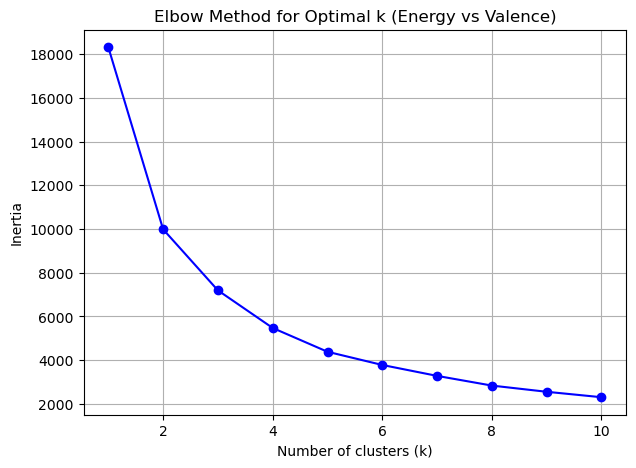

In [42]:
plt.figure(figsize=(7, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Energy vs Valence)')
plt.grid(True)
plt.show()

In [43]:
optimal_k = 4  # You can adjust this based on the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
subset['Cluster'] = kmeans.fit_predict(scaled_features)

In [44]:
# Inverse transform the cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)

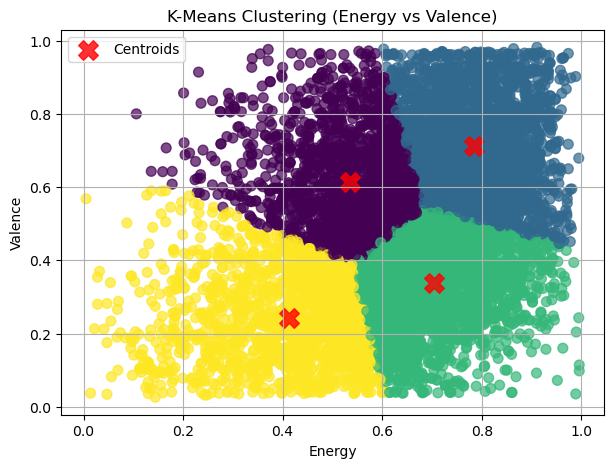

In [45]:
plt.figure(figsize=(7, 5))
plt.scatter(subset['Energy'], subset['Valence'],
            c=subset['Cluster'], cmap='viridis', s=50, alpha=0.7)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1],
            c='red', s=200, alpha=0.8, marker='X', label='Centroids')

plt.title('K-Means Clustering (Energy vs Valence)')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
print("\nCluster Centers (Original Scale):")
for i, center in enumerate(centers):
    print(f"Cluster {i}: Energy={center[0]:.3f}, Valence={center[1]:.3f}")
    
print("\nNumber of items in each cluster:")
print(subset['Cluster'].value_counts())


Cluster Centers (Original Scale):
Cluster 0: Energy=0.535, Valence=0.613
Cluster 1: Energy=0.785, Valence=0.712
Cluster 2: Energy=0.705, Valence=0.337
Cluster 3: Energy=0.412, Valence=0.241

Number of items in each cluster:
Cluster
2    2776
1    2693
0    1908
3    1784
Name: count, dtype: int64


In [47]:
print(f'Energy Mean : {np.mean(subset[['Energy']])}')
print(f'Valence Mean : {np.mean(subset[['Valence']])}')

Energy Mean : 0.6360761925553979
Valence Mean : 0.48646523305316014


In [48]:
def interpret_cluster(energy,Valence ):
    """Return a descriptive label based on cluster center characteristics."""
    if energy > 0.6 and Valence > 0.7:
        return "🎉 High Energy & Happy songs (energetic, uplifting mood)"
    elif energy < 0.6 and Valence < 0.6:
        return "💤 Low Energy & Sad songs (calm, mellow, emotional)"
    elif energy > 0.7 and Valence < 0.6:
        return "🔥 Energetic but Dark songs (intense, aggressive tone)"
    elif energy < 0.6 and Valence > 0.7:
        return "🌤️ Relaxed but Cheerful songs (chill, peaceful mood)"
    else:
        return "🎧 Moderate Energy & Neutral mood songs"

print("\nCluster Interpretations:")
for i, center in enumerate(centers):
    desc = interpret_cluster(center[0], center[1])
    print(f"Cluster {i}: {desc}")


Cluster Interpretations:
Cluster 0: 🎧 Moderate Energy & Neutral mood songs
Cluster 1: 🎉 High Energy & Happy songs (energetic, uplifting mood)
Cluster 2: 🔥 Energetic but Dark songs (intense, aggressive tone)
Cluster 3: 💤 Low Energy & Sad songs (calm, mellow, emotional)


In [49]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [50]:
train_data, test_data = train_test_split(
    subset[['Energy', 'Valence']],
    test_size=0.2,
    random_state=42
)

In [51]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[['Energy', 'Valence']])

In [52]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
train_data['Cluster'] = kmeans.fit_predict(train_scaled)

In [53]:
test_scaled = scaler.transform(test_data[['Energy', 'Valence']])
test_data['Cluster'] = pairwise_distances_argmin_min(test_scaled, kmeans.cluster_centers_)[0]

In [54]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers (Energy, Valence):\n", centers)

Cluster Centers (Energy, Valence):
 [[0.71949191 0.35913085]
 [0.53299729 0.61650779]
 [0.43433606 0.24059157]
 [0.7844843  0.72593572]]


In [55]:
sorted_clusters = sorted(
    [(i, c[0], c[1]) for i, c in enumerate(centers)],
    key=lambda x: (x[1], x[2])  # sort by Energy then Valence
)
print("\nCluster order (low → high energy, low → high valence):", sorted_clusters)

mood_map = {
    0: 'Depression',   # low energy, low valence
    1: 'Contentment',  # low energy, high valence
    2: 'Anxiety',      # high energy, low valence
    3: 'Exuberance'    # high energy, high valence
}

train_data['Mood'] = train_data['Cluster'].map(mood_map)
test_data['Mood'] = test_data['Cluster'].map(mood_map)


Cluster order (low → high energy, low → high valence): [(2, np.float64(0.43433606041535555), np.float64(0.240591567023285)), (1, np.float64(0.5329972918077184), np.float64(0.6165077860528098)), (0, np.float64(0.7194919064748202), np.float64(0.359130845323741)), (3, np.float64(0.7844842983316977), np.float64(0.7259357212953876))]


In [56]:
train_data['Energy'] += np.random.normal(0, 0.02, size=len(train_data))
test_data['Energy'] += np.random.normal(0, 0.02, size=len(test_data))

In [57]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,               # limit tree depth
    min_samples_split=20,      # avoid tiny splits
    min_samples_leaf=10,       # each leaf must have enough data
    random_state=42
)
rf.fit(train_data[['Energy', 'Valence']], train_data['Mood'])

RandomForestClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [58]:
y_pred = rf.predict(test_data[['Energy', 'Valence']])

print(" Model: Random Forest (Final) ")
print(f"Accuracy: {accuracy_score(test_data['Mood'], y_pred):.3f}\n")
print("Classification Report:\n")
print(classification_report(test_data['Mood'], y_pred))

 Model: Random Forest (Final) 
Accuracy: 0.921

Classification Report:

              precision    recall  f1-score   support

     Anxiety       0.92      0.93      0.93       410
 Contentment       0.92      0.89      0.90       408
  Depression       0.91      0.93      0.92       535
  Exuberance       0.93      0.93      0.93       480

    accuracy                           0.92      1833
   macro avg       0.92      0.92      0.92      1833
weighted avg       0.92      0.92      0.92      1833



In [59]:
y_train_pred = rf.predict(train_data[['Energy', 'Valence']])
y_test_pred = rf.predict(test_data[['Energy', 'Valence']])

In [60]:
# Accuracy
train_acc = accuracy_score(train_data['Mood'], y_train_pred)
test_acc = accuracy_score(test_data['Mood'], y_test_pred)

print("\n🎯 Model Performance Summary")
print(f"Training Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy : {test_acc:.3f}")


🎯 Model Performance Summary
Training Accuracy: 0.939
Testing Accuracy : 0.921
